<img src="../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Circuit Rewriting using the Transpiler

Previously we have performed basic operations on circuits, and ran those circuits on real quantum devices using the `execute` function.  `execute` is a helper function that performs three tasks for the user:

1) Circuits are rewritten to match the constraints of a given backend and optimized.

2) The rewritten circuits are packaged for submission.

3) The packaged circuits are submitted to the device.

The first step is called transpilation, and is the fundamental step required for running circuits on real quantum devices.  The qiskit function that does this is `transpile`, which takes a single or list of input circuits, as well as a collection of parameters, and returns a modified list of circuits.  Using this `transpile` function is the goal of this tutorial.

For those wishing to bypass this in-depth discussion of what happens during the transpilation process, we note that the standard way of calling the `transpile` function is:

```python
new_circuits = transpile(circuits, backend, optimization_level=1)
```

where `circuits` is a single or list of input circuits, `backend` is the target device, and `optimization_level` selects between four different `[0,1,2,3]` preset methods of circuit rewriting and optimization.  By default, `optimization_level=1`.

# Table of contents

1) [Introduction](#introduction)


2) [Basis Gates](#basis)


3) [Initial Layout](#layout)


4) [Mapping Circuits to Hardware](#mapping)


5) [Optimizing Gates](#optimizing)


6) [User Defined Topologies](#topology)


7) [Passing Transpiled Circuits to Devices](#passing)

In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')

## Introduction <a name='introduction'></a>

Consider the following circuit that creates a five-qubit GHZ state:

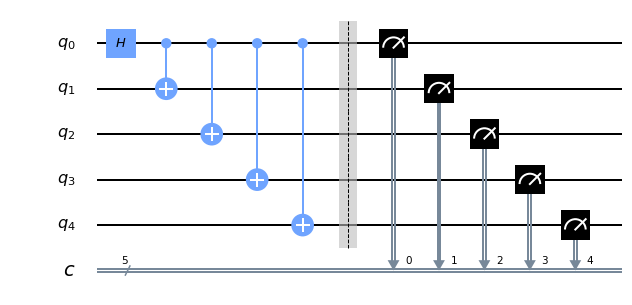

In [3]:
ghz = QuantumCircuit(5, 5)
ghz.h(0)
for idx in range(1,5):
    ghz.cx(0,idx)
ghz.barrier(range(5))
ghz.measure(range(5), range(5))
ghz.draw(output='mpl')

We would like to take this circuit and run it on an IBM Q quantum device.  However, in its original form, this circuit cannot be run.  This circuit, as is the case with most circuits, must undergo a series of transformations that make it compatible with a given target device, and optimize it to reduce the effects of noise on the resulting outcomes.

As we will see, rewriting quantum circuits to match hardware constraints and optimizing for performance can be far from trivial.  The flow of logic in the rewriting tool chain need not be linear, and can often have iterative sub-loops, conditional branches, and other complex behaviors.  That being said, the basic building blocks follow the structure given below.

<img src="images/transpiling_core_steps.png" style="width=auto;"/>

In what follows, we highlight the key steps in this workflow, and show how they modify circuits based on the value of keyword arguments passed to the `transpile` function.  The `transpile` function has many input arguments:

In [4]:
import inspect
inspect.signature(transpile)

<Signature (circuits, backend=None, basis_gates=None, coupling_map=None, backend_properties=None, initial_layout=None, seed_transpiler=None, optimization_level=None, pass_manager=None, callback=None, output_name=None)>

Here we focus only on the most important ones: `basis_gates`, `initial_layout` `optimization_level` and `coupling_map`.

## Basis Gates <a name='basis'></a>

When writing a quantum circuit you are free to use any quantum gate (unitary operator) that you like, along with a collection of non-gate operations such as qubit measurements and reset operations.  However, when running a circuit on a real quantum device one no longer has this flexibility.  Due to limitations in, for example, the physical interactions between qubits, difficulty in implementing multi-qubit gates, control electronics etc, a quantum computing device can only natively support a handful of quantum gates and non-gate operations. In the present case of IBM Q devices, the native gate set can be found by querying the devices themselves, and looking for the corresponding attribute in their configuration:

In [5]:
provider = IBMQ.get_provider(group='open')
provider.backends(simulator=False)

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [6]:
backend = provider.get_backend('ibmqx2')
backend.configuration().basis_gates

['u1', 'u2', 'u3', 'cx', 'id']

We see that the `ibmqx2` device supports five native gates: four single-qubit gates (`u1`, `u2`, `u3`, and `id`) and one two-qubit entangling gate `cx`.  In addition, the device supports qubit measurements (otherwise we can not read out an answer!).  Although we have queried only a single device, let us note that all IBM Q devices support this gate set.

The `u*` gates represent arbitrary single-qubit rotations of one, two, and three angles.  The `u1` gates are single-parameter rotations that represent generalized phase gates of the form

$$
U_{1}(\lambda) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\lambda}
\end{bmatrix}
$$

This set includes common gates such as $Z$, $T$, $T^{\dagger}$, $S$, and $S^{\dagger}$.  It turns out that these gates do not actually need to be performed on hardware, but instead, can be implemented in software as "virtual gates".  These virtual gates are called "frame changes" and take zero time, and have no associated error; they are free gates on hardware.

Two-angle rotations, $U_{2}(\phi,\lambda)$, are actually two frame changes with a single $X_{\pi/2}$ gate in between them, and can be used to synthesize gates like the Hadamard ($U_{2}(0,\pi)$) gate.  As the only actual gate performed is the $X_{\pi/2}$ gate, the error and gate time associated with any $U_{2}$ gate is the same as an $X_{\pi/2}$ gate.  Similarly, $U_{3}(\theta,\phi,\lambda)$ gates are formed from three frame changes with two $X_{\pi/2}$ gates in between them.  The errors and gate times are twice those of a single $X_{\pi/2}$.  The identity gate, $id$, is straightforward, and is a placeholder gate with a fixed time-interval. 

The only entangling gate supported by the IBM Q devices is the CNOT gate (`cx`) which, in the computational basis, can be written as:

$$
\mathrm{CNOT}(0,1) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

where the matrix form above follows from the specific bit-ordering convention used in Qiskit. (This was discussed in [Part 1: Getting Started with Qiskit](1_getting_started_with_qiskit.ipynb#Statevector-backend).)

Every quantum circuit run on an IBM Q device must be expressed using only these basis gates.  For example, suppose one wants to run a simple phase estimation circuit:

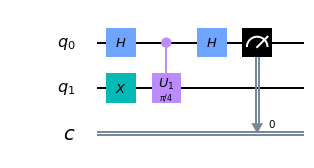

In [7]:
qc = QuantumCircuit(2, 1)

qc.h(0)
qc.x(1)
qc.cu1(np.pi/4, 0, 1)
qc.h(0)
qc.measure([0], [0])
qc.draw(output='mpl')

We have $H$, $X$, and controlled-$U_{1}$ gates, all of which are not in our devices basis gate set, and must be expanded.  This expansion is taken care of for us in the `execute` function.  However, we can decompose the circuit to show what it would look like in the native gate set of the IBM Q devices

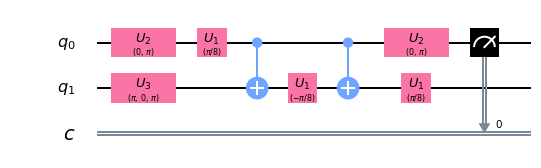

In [8]:
qc_basis = qc.decompose()
qc_basis.draw(output='mpl')

A few things to highlight.  One, as mentioned in [Part 4: Quantum Circuit Properties](4_quantum_circuit_properties.ipynb), the circuit has gotten longer with respect to the initial one.  This can be verified by checking the depth of the circuits:

In [9]:
print(qc.depth(), ',', qc_basis.depth())

4 , 7


Two, although we had a single controlled gate, the fact that it was not in the basis set means that, when expanded, it requires more than a single `cx` gate to implement. All said, unrolling to the basis set of gates leads to an increase in the depth of a quantum circuit and the number of gates.

It is important to highlight two special cases:

### SWAP Gate Decomposition

A SWAP gate is not a native gate on the IBM Q devices, and must be decomposed into three CNOT gates:

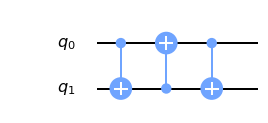

In [10]:
swap_circ = QuantumCircuit(2)
swap_circ.swap(0, 1)
swap_circ.decompose().draw(output='mpl')

As a product of three CNOT gates, SWAP gates are expensive operations to perform on a noisy quantum devices.  However, such operations are usually necessary for embedding a circuit into the limited entangling gate connectivities of actual devices.  Thus, minimizing the number of SWAP gates in a circuit is a primary goal in the transpilation process.

### Toffoli Gate Decomposition

A Toffoli, or controlled-controlled-not gate, is a three qubit gate.  Given that our basis gate set includes only single- and two-qubit gates, it is obvious that this gate must be decomposed.  This decomposition is quite costly.

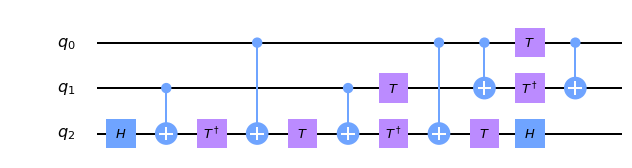

In [11]:
ccx_circ = QuantumCircuit(3)
ccx_circ.ccx(0, 1, 2)
ccx_circ.decompose().draw(output='mpl')

For every Toffoli gate in a quantum circuit, the IBM Q hardware may execute up to six CNOT gates, and a handful of single-qubit gates.  From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and will therefore be appreciably affected by noise and gate errors.

## Initial Layout <a name='layout'></a>

Quantum circuits are abstract entities whose qubits are "virtual" representations of actual qubits used in computations.  We need to be able to map these virtual qubits in a one-to-one manner to the "physical" qubits in an actual quantum device.

<img src="images/mapping.png" style="width=auto;">

By default, qiskit will do this mapping for you.  The choice of mapping depends on the properties of the circuit, the particular device you are targeting, and the optimization level that is chosen.  The basic mapping strategies are the following:

- **Trivial layout**: Map virtual qubits to the same numbered physical qubit on the device, i.e. `[0,1,2,3,4]` -> `[0,1,2,3,4]` (default in `optimization_level=0`).


- **Dense layout**: Find the sub-graph of the device with same number of qubits as the circuit with the greatest connectivity (default in `optimization_level=1`).


- **Noise adaptive layout**: Uses the noise properties of the device, in concert with the circuit properties, to generate the layout with the best noise properties (default in `optimization_level=2` and `optimization_level=3`).

The choice of initial layout is extremely important when:

1) Computing the number of SWAP operations needed to map the input circuit onto the device topology.

2) Taking into account the noise properties of the device.

As we will see, the choice of `initial_layout` can mean the difference between getting a result, and getting nothing but noise.

To begin, lets see what layouts are automatically picked at various optimization levels.  The modified circuits returned by `transpile` have this initial layout information in them, and we can view this layout selection graphically using `plot_circuit_layout`.  Let us pick the `ibmq_16_melbourne` device:

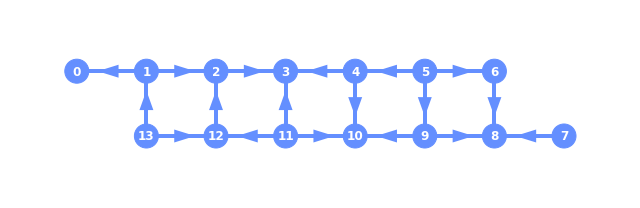

In [12]:
backend = provider.get_backend('ibmq_16_melbourne')
plot_gate_map(backend, plot_directed=True)

### Layout using `optimization_level=0`

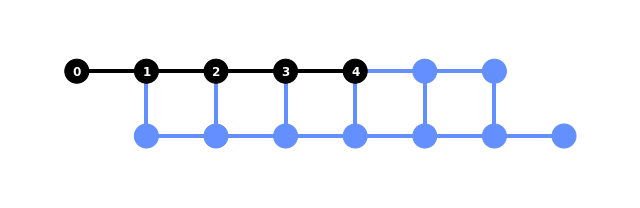

In [13]:
backend = provider.get_backend('ibmq_16_melbourne')
new_circ_lv0 = transpile(ghz, backend=backend, optimization_level=0)

plot_circuit_layout(new_circ_lv0, backend)

### Layout using `optimization_level=3`

Depth: 15


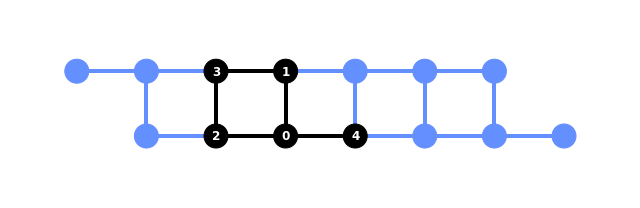

In [14]:
from qiskit.visualization import plot_circuit_layout

backend = provider.get_backend('ibmq_16_melbourne')
new_circ_lv3 = transpile(ghz, backend=backend, optimization_level=3)

print('Depth:', new_circ_lv3.depth())
plot_circuit_layout(new_circ_lv3, backend)

Let us now execute this level 3 circuit, and get the counts.  Note that the circuit has already been rewritten to match the target backend.  Therefore, the circuit will go unmodified by `execute` and be directly packaged and sent to the device.

In [15]:
job1 = execute(new_circ_lv3, backend)
job_monitor(job1)

Job Status: job has successfully run


### Specifying an Initial Layout

It is completely possible to specify your own initial layout.  To do so we can pass a list of integers to `transpile` via the `initial_layout` keyword argument, where the index labels the virtual qubit in the circuit and the corresponding value is the label for the physical qubit to map onto.  For example, lets map our GHZ circuit onto `ibmq_16_melbourne` in two different ways:

#### Good choice

Depth: 10


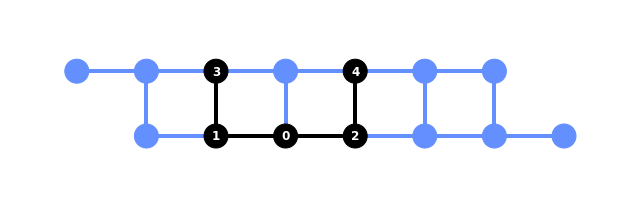

In [16]:
# Virtual -> physical
#    0    ->    11
#    1    ->    12
#    2    ->    10
#    3    ->    2
#    4    ->    4

good_ghz = transpile(ghz, backend, initial_layout=[11,12,10,2,4])
print('Depth:', good_ghz.depth())
plot_circuit_layout(good_ghz, backend)

In [17]:
job2 = execute(good_ghz, backend)
job_monitor(job2)

Job Status: job has successfully run


#### Bad choice

Depth: 50


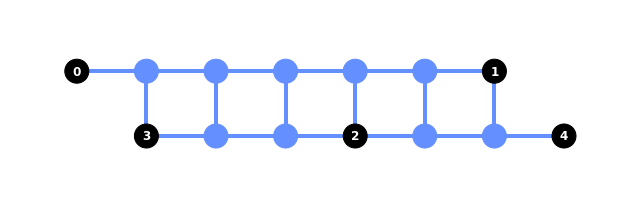

In [18]:
# Virtual -> physical
#    0    ->    0
#    1    ->    6
#    2    ->    10
#    3    ->    13
#    4    ->    7

bad_ghz = transpile(ghz, backend, initial_layout=[0,6,10,13,7])
print('Depth:', bad_ghz.depth())
plot_circuit_layout(bad_ghz, backend)

In [19]:
job3 = execute(bad_ghz, backend)
job_monitor(job3)

Job Status: job has successfully run


In [20]:
counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()
counts3 = job3.result().get_counts()

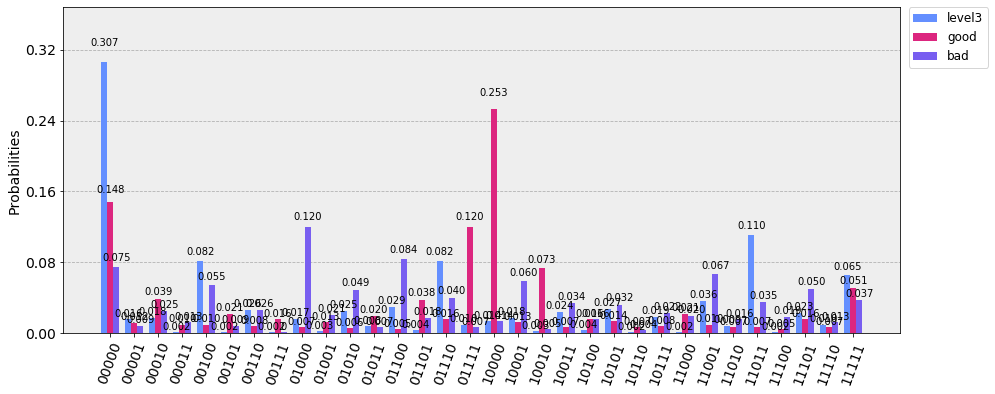

In [21]:
plot_histogram([counts1, counts2, counts3],
               figsize=(15,6),
               legend=['level3', 'good', 'bad'])

From the figure it is clear that the choice of initial layout is an extremely important step, and can mean the difference between a good answer and one dominated by noise.  Although the 'good' circuit has a smaller depth, the results generated by the "level 3"-circuit are more in line with the expected answer.  This is because our manual layout selection did not take into account the noise properties of the device.  Noise affects each qubit differently, and qubit measurement errors can also corrupt the answer.  The noise adaptive layout in `optimization_level=2` and `optimization_level=3` takes this into account, and the benefits are obvious.

### Being a bit Smarter

Picking a good `initial_layout` is critical, but it is not the only step in optimizing a circuit on a quantum device.  Often it is beneficial to rewrite a circuit, with the goal of targeting a specific device.  Our GHZ circuit can be perfectly mapped to the `ibmq_16_melbourne` device provided that we reformulate the gate sequence as:

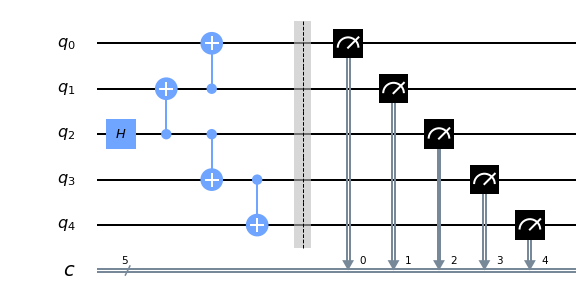

In [22]:
ghz2 = QuantumCircuit(5, 5)
ghz2.h(2)
ghz2.cx(2, 1)
ghz2.cx(1, 0)
ghz2.cx(2, 3)
ghz2.cx(3, 4)
ghz2.barrier(range(5))
ghz2.measure(range(5), range(5))
ghz2.draw(output='mpl')

This circuit can now be mapped exactly onto the device topology using `initial_layout=[10,4,5,6,8]`.  This can be verified by once again computing the depth.

Depth: 5


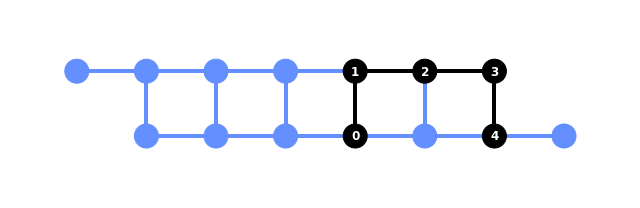

In [23]:
exact_ghz = transpile(ghz2, backend, initial_layout=[10,4,5,6,8])
print('Depth:', exact_ghz.depth())
plot_circuit_layout(exact_ghz, backend)

In [24]:
job4 = execute(exact_ghz, backend)
job_monitor(job4)

Job Status: job has successfully run


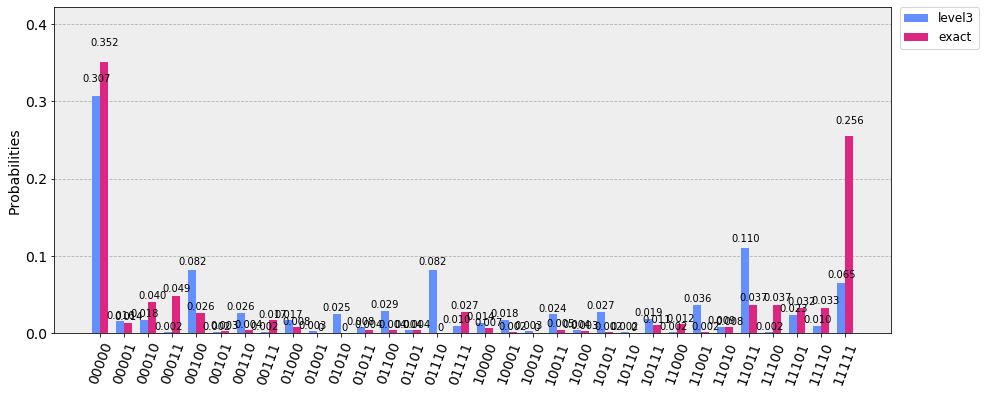

In [25]:
counts4 = job4.result().get_counts()
plot_histogram([counts1, counts4],
               figsize=(15,6),
               legend=['level3', 'exact'])

## Mapping Circuits to Hardware Topology <a name='mapping'></a>

Our original GHZ circuit consists of a single qubit (`0`) coupled to the others via CNOT gates.  If implemented directly, this would require hardware that has a single qubit coupled to four other qubits.  Looking at the gate maps of the public IBM Q hardware we see that there is one device that fits this description.

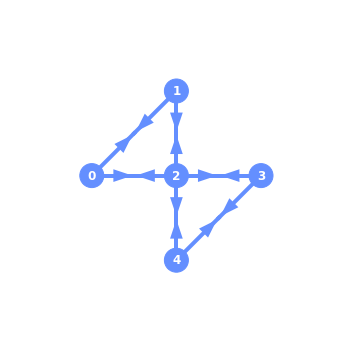

In [26]:
backend = provider.get_backend('ibmqx2')
plot_gate_map(backend, plot_directed=True)

and three that do not:

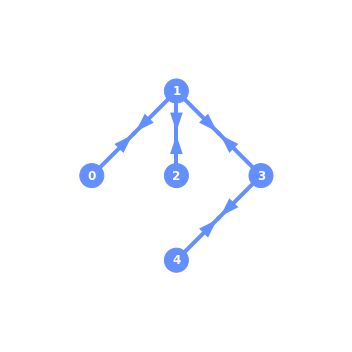

In [27]:
backend = provider.get_backend('ibmq_ourense')
plot_gate_map(backend, plot_directed=True)

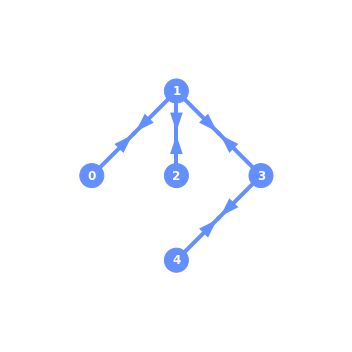

In [28]:
backend = provider.get_backend('ibmq_vigo')
plot_gate_map(backend, plot_directed=True)

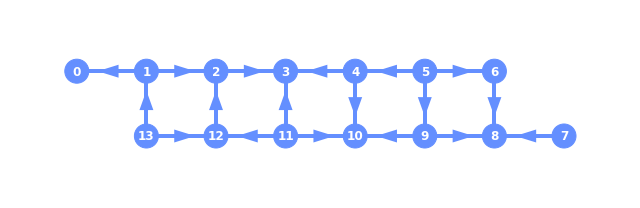

In [29]:
backend = provider.get_backend('ibmq_16_melbourne')
plot_gate_map(backend, plot_directed=True)

It seems our circuit is a good match to the `ibmqx2` topology provided that we map virtual qubit `0` to physical qubit `2`.  The arrows on the graphs above indicate that CNOT gates are only allowed in one direction.  However, flipping the direction of a CNOT gate is relatively trivial, and does not greatly affect the fidelity of the computation.

`ibmq_ourense`, `ibmq_vigo`, and `ibmq_16_melbourne` represent a problem.  There is no qubit anywhere that is connected to four others via CNOT gates.  In order to implement a CNOT gate between qubits that are not directly connected, one or more SWAP gates must be inserted into the circuit to move the qubit states around until they are adjacent on the device gate map.  Our choice of `initial_layout` in `job3` above was purposely designed to take many SWAP gates to make adjacent. As we have seen previously, each SWAP gate is decomposed into three CNOT gates on the IBM Q devices, and represents an expensive and noisy operation to perform.  Thus, finding the minimum number of SWAP gates needed to map a circuit onto a given device, is an important step (if not the most important) in the whole execution process.

As with many important things in life, finding the optimal SWAP mapping is hard.  In fact it is in a class of problems called NP-Hard, and is thus prohibitively expensive to compute for all but the smallest quantum devices and input circuits.  To get around this, by default Qiskit uses a stochastic heuristic algorithm called `StochasticSwap` to compute a good, but not necessarily minimal SWAP count.  The use of a stochastic method means the circuits generated by `transpile` (or `execute` that calls `transpile` internally) are not guaranteed to be the same over repeated runs.  Indeed, running the same circuit repeatedly will in general result in a distribution of circuit depths and gate counts at the output.

In order to highlight this, we run the GHZ circuit 100 times, using the "bad" (disconnected) `initial_layout` from the previous section:

In [30]:
bad_circs = transpile([ghz]*100, backend, initial_layout=[0,6,10,13,7])

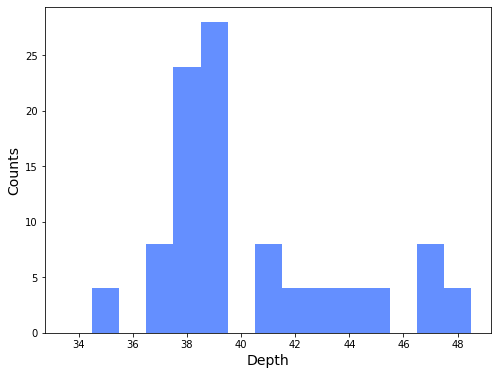

In [39]:
depths = [circ.depth() for circ in bad_circs]
plt.figure(figsize=(8,6))
plt.hist(depths, bins=list(range(34,50)), align='left', color='#648fff')
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Counts', fontsize=14);

This distribution is quite wide, signaling the difficultly the SWAP mapper is having in computing the best mapping.  Most circuits will have a distribution of depths, perhaps not as wide as this one, due to the stochastic nature of the default SWAP mapper.  Of course, we want the best circuit we can get, especially in cases where the depth is critical to success or failure.  In cases like this, it is best to `transpile` a circuit several times, e.g. 10, and take the one with the lowest depth.  The `transpile` function will automatically run in parallel mode, making this procedure relatively speedy in most cases.

Just to highlight the difference when running on a different device, we show the same distribution when using the `ibmqx2` backend with the default settings:

In [32]:
backend = provider.get_backend('ibmqx2')
qx2_circs = transpile([ghz]*100, backend)

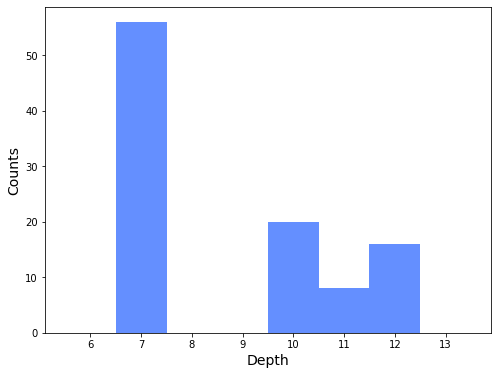

In [38]:
depths = [circ.depth() for circ in qx2_circs]
plt.figure(figsize=(8,6))
plt.hist(depths, bins=list(range(6,15)), align='left', color='#648fff')
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Counts', fontsize=14);

## Optimizing Single- and Multi-Qubit Gates <a name='optimizing'></a>

Decomposing quantum circuits into the basis gate set of the IBM Q devices, and the addition of SWAP gates needed to match hardware topology, conspire to increase the depth and gate count of quantum circuits.  Fortunately many routines for optimizing circuits by combining or eliminating gates exist.  In some cases these methods are so effective the output circuits have lower depth than the inputs.  In other cases, not much can be done, and the computation may be difficult to perform on noisy devices.  Different gate optimizations are turned on with different `optimization_level` values.  Below we show the benefits gained from setting the optimization level higher:

<div class="alert alert-block alert-success">
    <b>Remember:</b> The output from <code>transpile</code> varies due to the stochastic swap mapper.  So the numbers below will likely change each time you run the code.
</div>

In [40]:
backend = provider.get_backend('ibmq_16_melbourne')

In [41]:
circ0 = transpile(ghz, backend, optimization_level=0)
print('Depth:', circ0.depth())
print('Gate counts:', circ0.count_ops())

Depth: 25
Gate counts: OrderedDict([('u2', 29), ('cx', 19), ('measure', 5), ('barrier', 1)])


In [42]:
circ1 = transpile(ghz, backend, optimization_level=1)
print('Depth:', circ1.depth())
print('Gate counts:', circ1.count_ops())

Depth: 20
Gate counts: OrderedDict([('u2', 15), ('cx', 11), ('measure', 5), ('barrier', 1)])


In [43]:
circ2 = transpile(ghz, backend, optimization_level=2)
print('Depth:', circ2.depth())
print('Gate counts:', circ2.count_ops())

Depth: 14
Gate counts: OrderedDict([('u2', 9), ('cx', 8), ('measure', 5), ('barrier', 1)])


In [44]:
circ3 = transpile(ghz, backend, optimization_level=3)
print('Depth:', circ3.depth())
print('Gate counts:', circ3.count_ops())

Depth: 16
Gate counts: OrderedDict([('u2', 13), ('cx', 8), ('measure', 5), ('barrier', 1)])


## Transpiling for User Defined Topologies <a name='topology'></a>

Up to now, we have focused on rewriting and optimizing circuits for the IBM Q set of devices.  However, `transpile` is much more general than that, and can be used to map circuits onto user defined device topologies.  The topology is encoded in what qiskit calls the `coupling_map`, and the coupling map for a device can be obtained from its `configuration`:

In [45]:
backend = provider.get_backend('ibmqx2')
backend.configuration().coupling_map

[[0, 1],
 [0, 2],
 [1, 0],
 [1, 2],
 [2, 0],
 [2, 1],
 [2, 3],
 [2, 4],
 [3, 2],
 [3, 4],
 [4, 2],
 [4, 3]]

The elements of this list are `[control, target]` pairs that indicate that a CNOT gate can be performed using those qubits.  The coupling map is in essence an adjacency matrix characterizing the entangling gate coupling of the device:

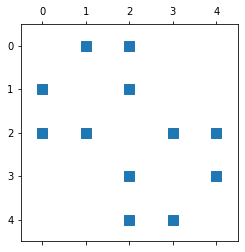

In [46]:
from scipy.sparse import coo_matrix
cmap = backend.configuration().coupling_map
rows = [c[0] for c in cmap]
cols = [c[1] for c in cmap]
data = np.ones_like(rows)
adj_matrix = coo_matrix((data,(rows,cols)),shape=(5,5))
plt.spy(adj_matrix);

If it is possible to perform CNOT gates in both directions on all pairs of qubits, then this matrix is symmetric.

We are free to construct our own device topology by defining our own `coupling_map` and using it in `transpile`.  For example, a five qubit linear nearest-neighbor (LNN) topology supporting bi-directional CNOT gates is written as:

In [47]:
lnn5 = [[0,1], [1,0], [1,2], [2,1], [2,3], [3,2], [3,4], [4,3]]

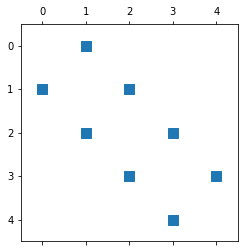

In [48]:
rows = [c[0] for c in lnn5]
cols = [c[1] for c in lnn5]
data = np.ones_like(rows)
adj_matrix = coo_matrix((data,(rows,cols)),shape=(5,5))
plt.spy(adj_matrix);

We can then use this `coupling_map` in place of an actual backend as follows:

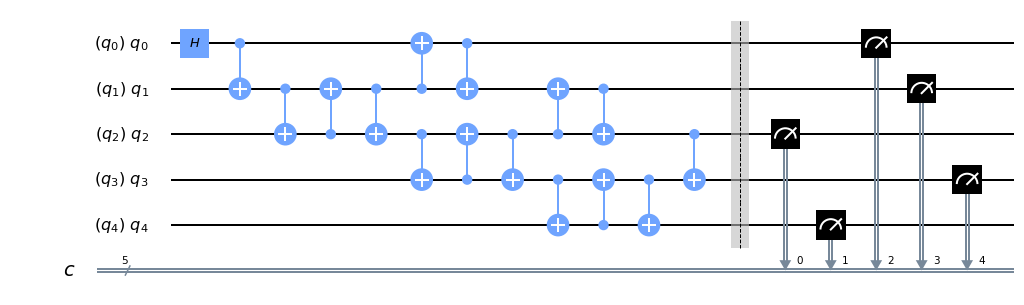

In [49]:
lnn5_circ = transpile(ghz, backend=None, coupling_map=lnn5)
lnn5_circ.draw(output='mpl')

Or we can write a directional five qubit '+' shaped topology, with all directional CNOT gates pointing to the center as:

In [50]:
plus = [[0,2], [1,2], [3,2], [4,2]]

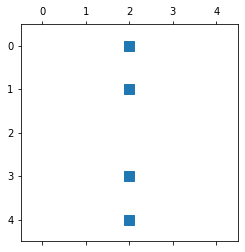

In [51]:
rows = [c[0] for c in plus]
cols = [c[1] for c in plus]
data = np.ones_like(rows)
adj_matrix = coo_matrix((data,(rows,cols)),shape=(5,5))
plt.spy(adj_matrix);

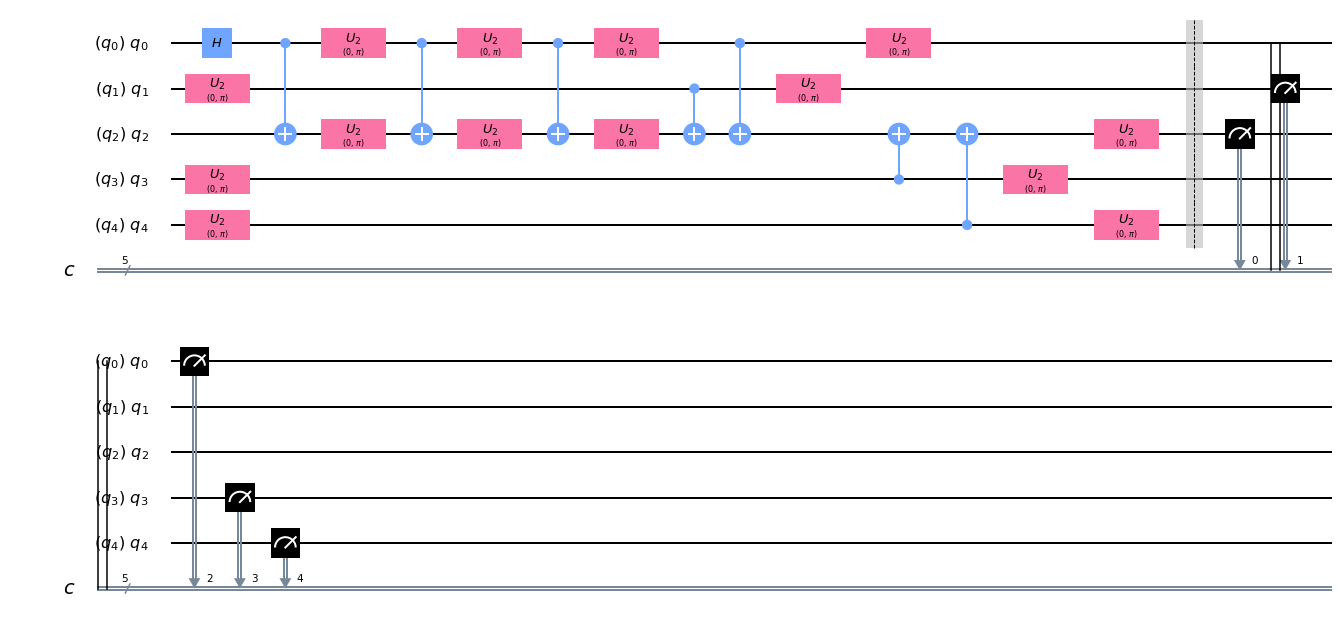

In [52]:
plus_circ = transpile(ghz, backend=None, coupling_map=plus)
plus_circ.draw(output='mpl')

In the above examples we can see that a Hadamard gate is still in the circuit.  This is because with `backend=None` we also need to specify the `basis_gates` if we want a specific gate set at the end.

## Passing Transpiled Circuits to a Backend <a name='passing'></a>

Now that we have transpiled circuits, the final step is to pass them to a backend for execution.  There are two ways of doing this:

1) Pass the circuits to `execute` as done before.

2) Use the `assemble` function to package them, and then call the backend directly.

### Using `execute` with transpiled circuits

Typically one is interested in transpiling circuits for the same backend that they intend to run their circuits on.  In this case, the circuits have already been mapped to the backend and optimized, so calling:

```
job = execute(transpiled_circuits, backend, **kwargs)
```
will simply package the circuits up, and send them to the target backend.  The exception to this rule is if the level of optimization is different than what the circuits were originally transpiled with.  That is to say setting `optimization_level=3` in `execute` while passing circuits transpiled under `optimization_level=1` (the default) will undergo further optimization before being sent to the device.

### Packaging Circuits with `assemble`

It is also possible to skip the `execute` function and bundle the transpiled circuits using the `assemble` function.  The `assemble` function is designed to take both, circuits and pulse schedules, and has lots of input arguments:

In [53]:
inspect.signature(assemble)

<Signature (experiments, backend=None, qobj_id=None, qobj_header=None, shots=1024, memory=False, max_credits=None, seed_simulator=None, qubit_lo_freq=None, meas_lo_freq=None, qubit_lo_range=None, meas_lo_range=None, schedule_los=None, meas_level=2, meas_return='avg', meas_map=None, memory_slot_size=100, rep_time=None, parameter_binds=None, **run_config)>

many of which overlap with those in `execute`.  Here `experiments` is the circuit or list of circuits to be run, and `backend` is of course the backend you are targeting.  The other important ones are:

- **shots** - Number of times to execute each circuit.

- **memory** - Return the resulting bitstring for each shot rather than collecting counts.

A standard call to `assemble` would look like:

```
qobj = assemble(transpiled_circuits, backend, shots=2048)
```

where `qobj` is the container format used in sending circuits (and pulse experiments) to the devices.  This `qobj` can be run by calling the `backend` directly:

```
job = backend.run(qobj)
```

which will return a `job` just like `execute`.

In [54]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright